In [1]:
import signal
import sys
import warnings
from copy import deepcopy

import numpy as np
import sncosmo
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sndata.csp import dr1, dr3
from tqdm import tqdm_notebook

sys.path.insert(0, '../')
from analysis_pipeline import models, classification
from analysis_pipeline.utils import split_data, calc_model_chisq as calc_chisq

warnings.simplefilter('ignore')


## Load and register data

In [2]:
# Download and register data
dr1.download_module_data()
dr3.download_module_data()
dr3.register_filters(force=True)
models.register_sources(force=True)


## Define classification functions

In [3]:
def classify_fix_salt2_t0(
    all_data, red_data, blue_data, kwargs_s2=dict(), kwargs_bg=dict(),show_plots=False):
    """Determine the classification coordinates for a given target
    
    Args:
        data             (Table): Table of light curve data for SNCosmo
        band_names   (list[str]): Band names of the parent survey
        lambda_eff (list[float]): Effective wavelength for each band
    
    Returns:
       The x and y classification coordinates
    """
    
    # Parse data
    z = all_data.meta['redshift']    
    vparmas = ['t0', 'x0', 'x1', 'c']

    # Load models
    salt2 = sncosmo.Model('salt2')
    sn91bg = sncosmo.Model(source=sncosmo.get_source('sn91bg', version='salt2_phase'))

    # Fit salt2 model with fixed redshift
    salt2.set(z=z)
    norm_result_all, norm_fit_all = sncosmo.fit_lc(all_data, salt2, vparmas, **kwargs_s2)

    salt2.set(z=z, t0=norm_fit_all.parameters[1])
    sn91bg.set(z=z, t0=norm_fit_all.parameters[1])
    
    norm_result_red, norm_fit_red = sncosmo.fit_lc(red_data, salt2, vparmas[1:], **kwargs_s2)
    norm_result_blue, norm_fit_blue = sncosmo.fit_lc(blue_data, salt2, vparmas[1:], **kwargs_s2)
    bg_result_all, bg_fit_all = sncosmo.fit_lc(all_data, sn91bg, vparmas[1:], **kwargs_bg)
    bg_result_red, bg_fit_red = sncosmo.fit_lc(red_data, sn91bg, vparmas[1:], **kwargs_bg)
    bg_result_blue, bg_fit_blue = sncosmo.fit_lc(blue_data, sn91bg, vparmas[1:], **kwargs_bg)

    if show_plots:
        print('Salt2')
        sncosmo.plot_lc(all_data, norm_fit_all)
        sncosmo.plot_lc(red_data, norm_fit_red)
        sncosmo.plot_lc(blue_data, norm_fit_blue)
        plt.show()

        print('91bg')
        sncosmo.plot_lc(all_data, bg_fit_all)
        sncosmo.plot_lc(red_data, bg_fit_red)
        sncosmo.plot_lc(blue_data, bg_fit_blue)
        plt.show()

    # Calculate chisq
    norm_blue_chisq = np.divide(*calc_chisq(blue_data, norm_fit_blue))
    norm_red_chisq = np.divide(*calc_chisq(red_data, norm_fit_red))
    bg_blue_chisq = np.divide(*calc_chisq(blue_data, bg_fit_blue))
    bg_red_chisq = np.divide(*calc_chisq(red_data, bg_fit_red))
    
    return (norm_blue_chisq - bg_blue_chisq, norm_red_chisq - bg_red_chisq)


In [4]:
def classify_set_salt2_t0(
    all_data, red_data, blue_data, vparams, kwargs_s2=dict(), kwargs_bg=dict(),show_plots=False):
    """Determine the classification coordinates for a given target
    
    Args:
        data             (Table): Table of light curve data for SNCosmo
        band_names   (list[str]): Band names of the parent survey
        lambda_eff (list[float]): Effective wavelength for each band
    
    Returns:
       The x and y classification coordinates
    """
    
    kwargs_s2 = kwargs_s2.copy()
    kwargs_bg = kwargs_bg.copy()

    # Load models
    salt2 = sncosmo.Model('salt2')
    sn91bg = sncosmo.Model(source=sncosmo.get_source('sn91bg', version='salt2_phase'))
    
    # Set redshift if not fitting for it
    if 'z' not in vparams:
        z = all_data.meta['redshift']
        salt2.set(z=z)
        sn91bg.set(z=z)

    # Fit salt2 model to determine t0
    norm_result_all, norm_fit_all = sncosmo.fit_lc(all_data, salt2, vparams, **kwargs_s2)
    t0=norm_fit_all.parameters[1]
    
    # Set initial t0 value for remainder of fits
    salt2.set(t0=t0)
    sn91bg.set(t0=t0)
    kwargs_bg['bounds'] = kwargs_bg.get('bounds', {})
    kwargs_bg['bounds']['t0'] = (t0 - 3, t0 + 3)
    
    norm_result_red, norm_fit_red = sncosmo.fit_lc(red_data, salt2, vparams, **kwargs_s2)
    norm_result_blue, norm_fit_blue = sncosmo.fit_lc(blue_data, salt2, vparams, **kwargs_s2)
    bg_result_all, bg_fit_all = sncosmo.fit_lc(all_data, sn91bg, vparams, **kwargs_bg)
    bg_result_red, bg_fit_red = sncosmo.fit_lc(red_data, sn91bg, vparams, **kwargs_bg)
    bg_result_blue, bg_fit_blue = sncosmo.fit_lc(blue_data, sn91bg, vparams, **kwargs_bg)
    
    if show_plots:
        print('Salt2')
        sncosmo.plot_lc(all_data, norm_fit_all)
        sncosmo.plot_lc(red_data, norm_fit_red)
        sncosmo.plot_lc(blue_data, norm_fit_blue)
        plt.show()

        print('91bg')
        sncosmo.plot_lc(all_data, bg_fit_all)
        sncosmo.plot_lc(red_data, bg_fit_red)
        sncosmo.plot_lc(blue_data, bg_fit_blue)
        plt.show()
    
    # Calculate chisq
    norm_blue_chisq = np.divide(*calc_chisq(blue_data, norm_fit_blue))
    norm_red_chisq = np.divide(*calc_chisq(red_data, norm_fit_red))
    bg_blue_chisq = np.divide(*calc_chisq(blue_data, bg_fit_blue))
    bg_red_chisq = np.divide(*calc_chisq(red_data, bg_fit_red))
    print('norm_blue_chisq', norm_blue_chisq)
    print('norm_red_chisq', norm_red_chisq)
    print('bg_blue_chisq', bg_blue_chisq)
    print('bg_red_chisq', bg_red_chisq)
    
    
    return (norm_blue_chisq - bg_blue_chisq, norm_red_chisq - bg_red_chisq)



In [5]:
class timeout:
    """A timeout context manager"""

    def __init__(self, seconds=1, error_message='Timeout'):
        """A timeout context manager
        Args:
            seconds       (int): The number of seconds until timeout
            error_message (str): The TimeOutError message on timeout
        """

        self.seconds = seconds
        self.error_message = error_message

    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)

    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)

    def __exit__(self, type_, value, traceback):
        signal.alarm(0)


def classify_survey(survey, obj_ids, class_func, timeout_seconds=30):
    # Get classification coordinates for each target

    bands = survey.band_names
    leff = survey.lambda_effective

    x, y = [], []
    for obj_id in tqdm_notebook(obj_ids):
        all_data_table = survey.get_data_for_id(obj_id, True)
        red_data_table, blue_data_table = split_data(all_data_table, bands, leff)

        try:
            with timeout(timeout_seconds):
                x_this, y_this = class_func(
                    all_data_table, red_data_table, blue_data_table, vparams=('t0', 'x0', 'x1', 'c'),
                    kwargs_bg=dict(bounds={'x1': [0.65, 1.25], 'c': [0, 1]})
                )

        except KeyboardInterrupt:
            raise
        
        except:
            x.append(np.NAN)
            y.append(np.NAN)    

        else:
            x.append(x_this)
            y.append(y_this)

    return x, y


## Run classifications

In [6]:
# Get list of targets that are spectroscopically classified
dr1_table_1 = dr1.load_table(1)
is_typed = ~dr1_table_1['Type'].mask
classifications = dr1_table_1['SN', 'Type'][is_typed]
classifications.show_in_notebook(display_length=10)


idx,SN,Type
0,2004dt,Normal
1,2004ef,Normal
2,2004eo,Normal
3,2004ey,Normal
4,2004gc,Normal
5,2004gs,Normal
6,2004gu,Normal
7,2005A,Normal
8,2005M,91T
9,2005ag,Normal


In [7]:
assert False
x, y = classify_survey(dr3, classifications['SN'], classify_set_salt2_t0)
classifications['x'] = x
classifications['y'] = y
classifications[:10]

plt.figure(figsize=(10, 10))
for snclass in set(classifications['Type']):
    plot_data = classifications[classifications['Type'] == snclass]
    plt.scatter(plot_data['x'], plot_data['y'], label=snclass)

plt.axvline(0, linestyle='--', color='grey')
plt.axhline(0, linestyle='--', color='grey')
plt.xlabel(r'$\chi^2_{blue}(Ia) - \chi^2_{blue}(91bg)$', fontsize=14)
plt.ylabel(r'$\chi^2_{red}(Ia) - \chi^2_{red}(91bg)$', fontsize=14)
plt.legend()
plt.show()

classifications

AssertionError: 

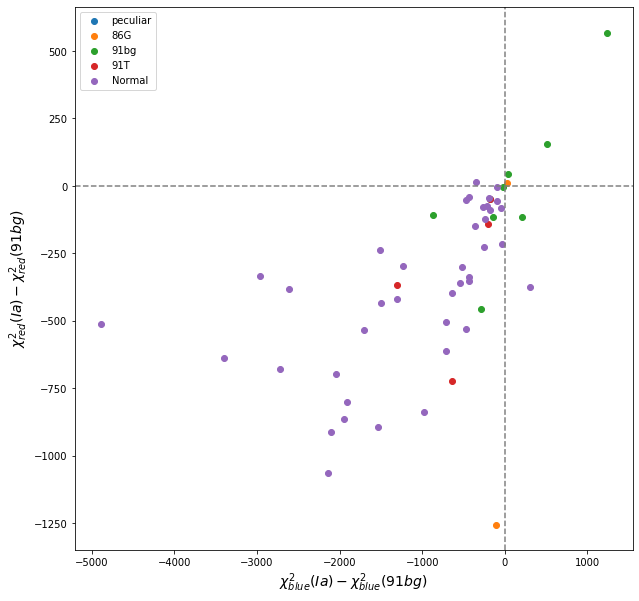

In [70]:
from astropy.table import Table
fits = Table.read('/Users/daniel/Github/SDSS-Classification/analysis_results/csp_dr3_simple_fit_fits.ecsv')
fits = Table(fits, masked=True)
fits = fits[~fits['band_set'].mask]
t = classification.classify_targets(fits)

plt.figure(figsize=(10, 10))
for snclass in set(classifications['Type']):
    indices = np.isin(t['obj_id'], classifications[classifications['Type'] == snclass]['SN'])
    plot_data = t[indices]
    plt.scatter(plot_data['y'], plot_data['x'], label=snclass)

plt.axvline(0, linestyle='--', color='grey')
plt.axhline(0, linestyle='--', color='grey')
plt.xlabel(r'$\chi^2_{blue}(Ia) - \chi^2_{blue}(91bg)$', fontsize=14)
plt.ylabel(r'$\chi^2_{red}(Ia) - \chi^2_{red}(91bg)$', fontsize=14)
plt.legend()
plt.show()


Salt2


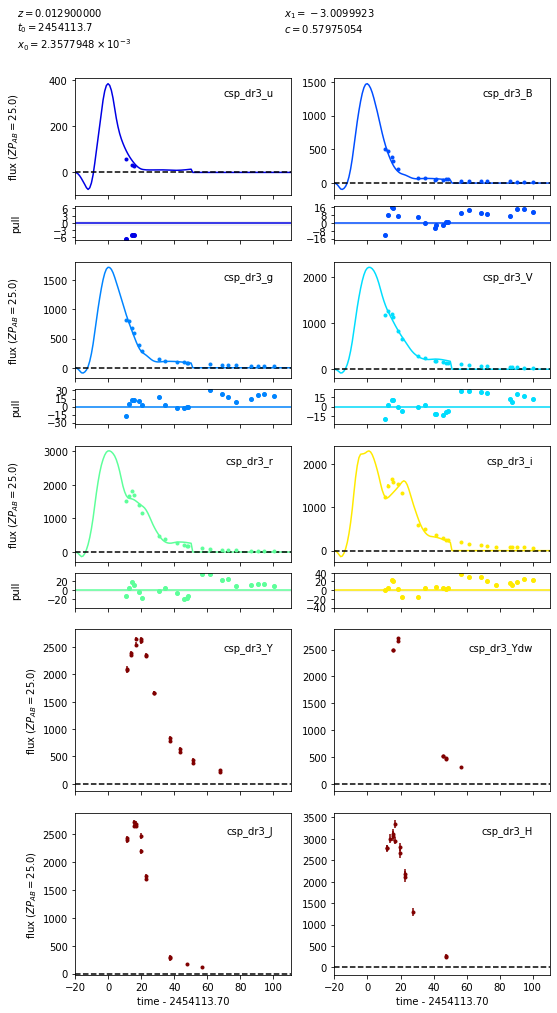

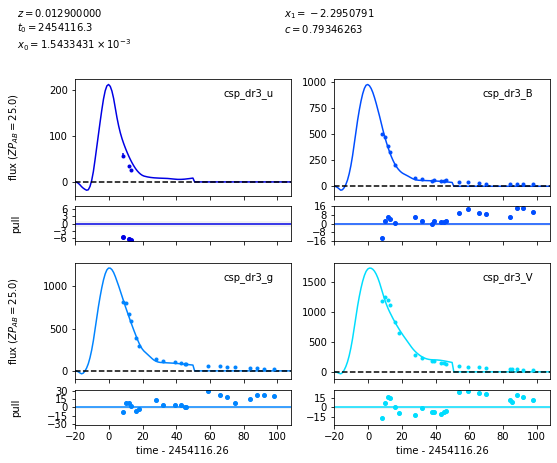

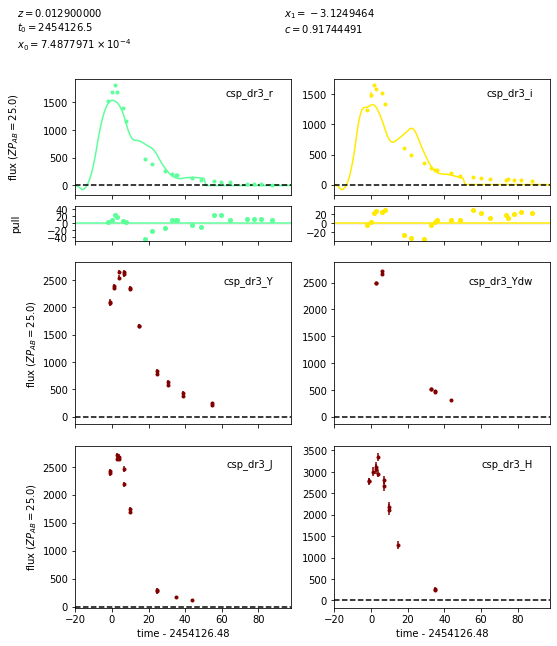

91bg


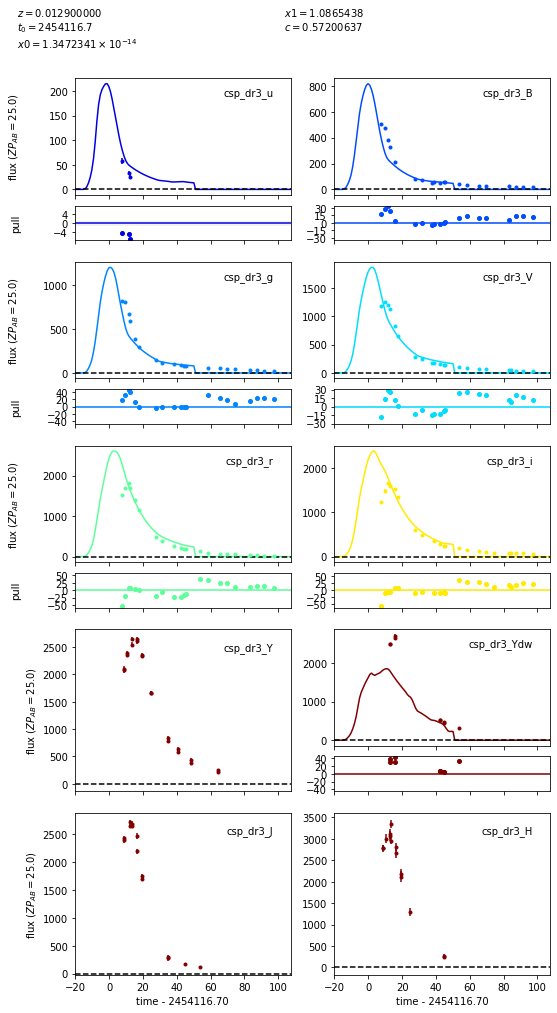

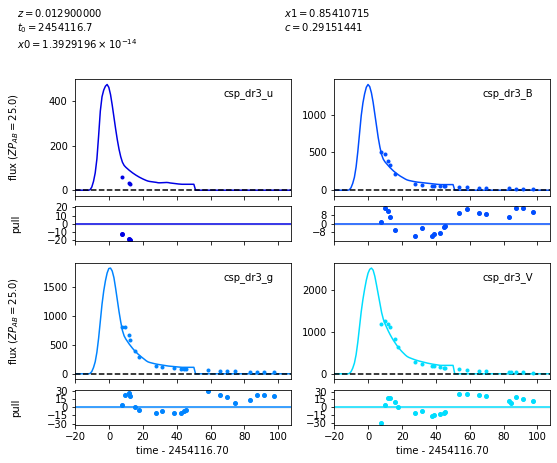

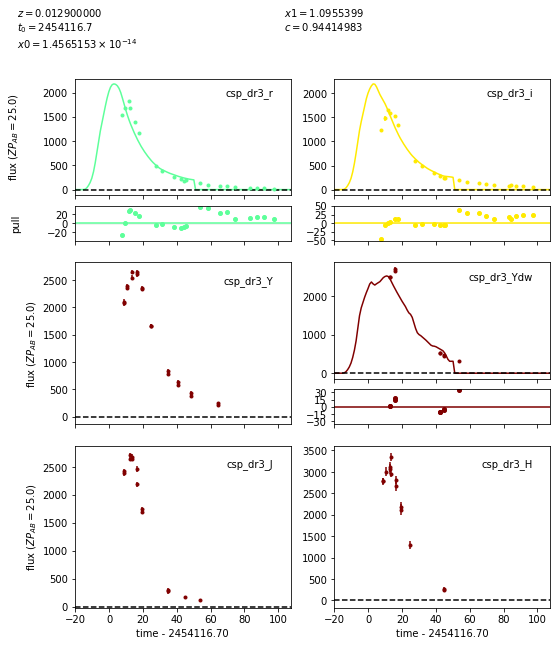

norm_blue_chisq 353.9684641815682
norm_red_chisq 65.38183232932923
bg_blue_chisq 1221.338099944031
bg_red_chisq 174.5911291652733


(-867.3696357624628, -109.20929683594406)

In [79]:
all_data_table = dr3.get_data_for_id('2007N', True)
red_data_table, blue_data_table = split_data(all_data_table, dr3.band_names, dr3.lambda_effective)
classify_set_salt2_t0(
    all_data_table, red_data_table, blue_data_table, 
    vparams=['t0', 'x0', 'x1', 'c'],
    kwargs_bg=dict(bounds={'x1': [0.65, 1.25], 'c': [0, 1]}),
    show_plots=True
)

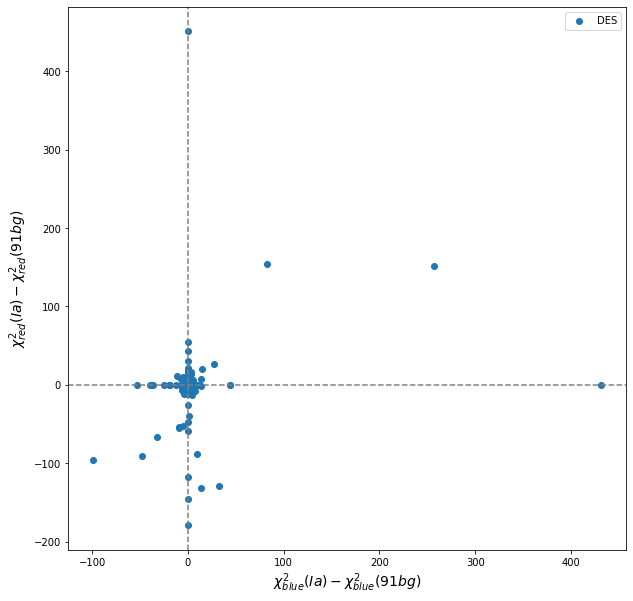

In [62]:
from astropy.table import Table
fits = Table.read('/Users/daniel/Github/SDSS-Classification/analysis_results/des_sn3yr_simple_fit_fits.ecsv')
fits = Table(fits, masked=True)
fits = fits[~fits['band_set'].mask]
t = classification.classify_targets(fits)

plt.figure(figsize=(10, 10))
plt.scatter(t['y'], t['x'], label='DES')

plt.axvline(0, linestyle='--', color='grey')
plt.axhline(0, linestyle='--', color='grey')
plt.xlabel(r'$\chi^2_{blue}(Ia) - \chi^2_{blue}(91bg)$', fontsize=14)
plt.ylabel(r'$\chi^2_{red}(Ia) - \chi^2_{red}(91bg)$', fontsize=14)
plt.legend()
plt.show()



In [35]:
t

obj_id,x,y
str100,float64,float64
01248677,-0.003046744118364586,-0.000249617966801452
01250017,-9.279780874749122e-05,-0.00041363019579421234
01253039,-5.896466562907122,2.827872297213581
01253101,-4.131656063771658,-3.065667309698483e-05
01253920,54.49475873131075,0.11305497548664789
01255502,-88.09648101448784,9.662675902703427
01257366,-0.7029742722935453,-3.9178096230330084e-05
01257695,-129.5956465225015,32.095273381875245
01258906,6.818603585734763,-7.0815856663682695


In [ ]:
sn91bg = sncosmo.Model('sn91bg')
sn91bg.set(z=0.0158, t0=2453303.183492493, x0=3.433919815165609e-14, x1=1.2499868289057758, c=0.008856923933008576)
data = dr3.get_data_for_id('2004ey', True)

sncosmo.chisq(data, sn91bg)